LSTM_Seq2Seq

0. flow 전처리 (IQR, Savgol)
1. weather 전처리 (차분)
2. flow & weather merge
3~5. sliding window → split → 정규화
6. Model
7~8. 

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random, os, copy

N_RUNS = 3
SEEDS = [42, 123, 7]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Multi-run: {N_RUNS} runs, seeds={SEEDS}")

Multi-run: 3 runs, seeds=[42, 123, 7]


0. flow, weather 데이터 Load

In [ ]:
BASE_DIR = Path.cwd().parent

# Flow raw data 로드 (J배수지, reservoir/10.csv)
flow_file = BASE_DIR / "data" / "rawdata" / "reservoir" / "10.csv"

# A배수지
# flow_file = BASE_DIR / "data" / "rawdata" / "reservoir" / "40.csv"

# D배수지
#flow_file = BASE_DIR / "data" / "rawdata" / "reservoir" / "33.csv"
df_flow = pd.read_csv(
    flow_file,
    header=None,
    usecols=[1, 2],
    names=['time', 'value']
).sort_values('time').reset_index(drop=True)

df_flow['time'] = pd.to_datetime(df_flow['time'], errors='coerce')
df_flow = df_flow.dropna(subset=['time'])
print(f"Flow 원본: {len(df_flow):,}개 ({df_flow['time'].min()} ~ {df_flow['time'].max()})")

# Weather 파일 경로
weather_file = BASE_DIR / "data" / "rawdata" / "weather"

Flow 원본: 943,452개 (2023-01-01 00:01:00 ~ 2024-10-17 17:37:00)


0-1. Flow 전처리
- IQR 이상치 + 음수 + 급변동 제거 → NaN
- Linear interpolation (양방향)
- Savitzky-Golay filter (window=51, polyorder=2)

In [3]:
from scipy.signal import savgol_filter

# 1. IQR 이상치 + 음수 + 급변동 → NaN 처리
Q1 = df_flow['value'].quantile(0.25)
Q3 = df_flow['value'].quantile(0.75)
IQR = Q3 - Q1

iqr_mask = (df_flow['value'] < Q1 - 1.5 * IQR) | (df_flow['value'] > Q3 + 1.5 * IQR)
negative_mask = df_flow['value'] < 0
diff = df_flow['value'].diff().abs()
spike_threshold = diff.quantile(0.999)
spike_mask = diff > spike_threshold

total_mask = iqr_mask | negative_mask | spike_mask
df_flow.loc[total_mask, 'value'] = np.nan

print(f"이상치 제거: IQR={iqr_mask.sum()}, 음수={negative_mask.sum()}, "
      f"급변동(>{spike_threshold:.2f})={spike_mask.sum()}, 총={total_mask.sum()}")

# 2. Linear interpolation (양방향) + clip
df_flow['value'] = df_flow['value'].interpolate(method='linear', limit_direction='both')
df_flow['value'] = df_flow['value'].clip(lower=0)

# 3. Savitzky-Golay filter (노이즈 제거, window=51, polyorder=2)
df_flow['value'] = savgol_filter(df_flow['value'], window_length=51, polyorder=2)
df_flow['value'] = df_flow['value'].clip(lower=0)

print(f"전처리 완료: {len(df_flow):,}개, "
      f"범위 [{df_flow['value'].min():.2f}, {df_flow['value'].max():.2f}]")

이상치 제거: IQR=238, 음수=0, 급변동(>100.00)=926, 총=1160
전처리 완료: 943,452개, 범위 [65.78, 538.22]


In [4]:
# 전처리 결과 저장 (원본 보호 + 재현성)
save_path = BASE_DIR / "data" / "processed" / "flow_preprocessed.csv"
df_flow.to_csv(save_path, index=False)
print(f"저장 완료: {save_path} ({len(df_flow):,}행)")

저장 완료: /home/kp/web/work/pro/data/processed/flow_preprocessed.csv (943,452행)


- weather 데이터 인코딩, concat

In [5]:
def read_weather_csv(f):
    for enc in ["euc-kr", "cp949", "utf-8", "utf-8-sig"]:
        try:
            return pd.read_csv(f, encoding=enc)
        except (UnicodeDecodeError, UnicodeError):
            continue
    raise ValueError(f"인코딩 실패: {f.name}")

files = sorted(f for f in weather_file.glob("SYNOP*.csv"))
print(f"읽을 파일 수: {len(files)}")

weather = pd.concat(
    [read_weather_csv(f) for f in files],
    ignore_index=True
)
print(f"concat 후 행 수: {len(weather):,}")

읽을 파일 수: 22
concat 후 행 수: 942,510


- 데이터 저장

In [6]:
# weather 전체 concat 결과 저장 (원본 보호)
weather.to_csv(BASE_DIR / "data" / "processed" / "weather_total_raw.csv", index=False, encoding="utf-8-sig")

1. weather 전처리 (★ Rainfall: 차분 변환 — v2 동일)

In [ ]:
weather['일시'] = pd.to_datetime(weather['일시'])

# 결측 처리: 강수량 0 채움, 기온/습도 linear 보간 (최대 60분 gap)
weather['0.5mm 일 누적 강수량(mm)'] = weather['0.5mm 일 누적 강수량(mm)'].fillna(0)
weather['기온(℃)'] = weather['기온(℃)'].interpolate(method='linear', limit=60)
weather['상대습도(%)'] = weather['상대습도(%)'].interpolate(method='linear', limit=60)

# ★ [개선 5] Rainfall 차분 변환: 일 누적 → 분당 변화량
# 원본: 0시에 리셋되며 단조 증가하는 누적값 → LSTM이 리셋 패턴 학습 어려움
# 차분: diff()로 변화량 추출 + 음수(리셋 시점)는 0으로 클리핑
rainfall_raw = weather['0.5mm 일 누적 강수량(mm)'].copy()
rainfall_diff = rainfall_raw.diff().fillna(0)
rainfall_diff = rainfall_diff.clip(lower=0)  # 0시 리셋(음수 차분) → 0

print(f"Rainfall 변환: 누적 → 차분")
print(f"  원본 범위: [{rainfall_raw.min():.2f}, {rainfall_raw.max():.2f}]")
print(f"  차분 범위: [{rainfall_diff.min():.4f}, {rainfall_diff.max():.4f}]")
print(f"  비영점 비율: {(rainfall_diff > 0).mean()*100:.1f}%")

weather['0.5mm 일 누적 강수량(mm)'] = rainfall_diff

# 장기 결측(>60분) 행 제거 — LSTM이 가짜 패턴 학습 방지
before = len(weather)
weather = weather.dropna(subset=['기온(℃)', '상대습도(%)'])
print(f'장기 결측 제거: {before:,} -> {len(weather):,} ({len(weather)/before*100:.1f}% 유지)')

weather = weather.rename(columns={
    '일시': 'datetime',
    '기온(℃)': 'temperature',
    '0.5mm 일 누적 강수량(mm)': 'rainfall',
    '상대습도(%)': 'humidity',
})

# 중복 timestamp 제거 (첫 번째 행 유지)
weather = weather.drop_duplicates(subset='datetime', keep='first')
weather = weather.sort_values('datetime').reset_index(drop=True)

# 시간 불연속 경계 표시 — segment 단위 sliding window용
time_diff = weather['datetime'].diff()
seg_boundary = time_diff > pd.Timedelta(minutes=1)
weather['segment_id'] = seg_boundary.cumsum()
print(f'연속 세그먼트 수: {weather["segment_id"].nunique()}')
print(weather.shape)
print(weather.head())

Rainfall 변환: 누적 → 차분
  원본 범위: [0.00, 160.00]
  차분 범위: [0.0000, 119.0000]
  비영점 비율: 0.3%
장기 결측 제거: 942,510 -> 894,039 (94.9% 유지)
연속 세그먼트 수: 3564
(894039, 5)
             datetime  temperature  rainfall  humidity  segment_id
0 2023-01-01 00:01:00         -3.3       0.0      91.6           0
1 2023-01-01 00:02:00         -3.3       0.0      91.6           0
2 2023-01-01 00:03:00         -3.3       0.0      91.6           0
3 2023-01-01 00:04:00         -3.2       0.0      91.6           0
4 2023-01-01 00:05:00         -3.2       0.0      91.6           0


In [8]:
weather.describe()

,datetime,temperature,rainfall,humidity,segment_id
count,894039,894039.000000,894039.000000,894039.000000,894039.000000
mean,2023-12-09 07:18:45.749011,15.358957,0.002827,71.807508,1596.019969
min,2023-01-01 00:01:00,-16.500000,0.000000,2.900000,0.000000
25%,2023-07-03 09:58:30,6.300000,0.000000,57.200000,465.000000
50%,2023-12-13 20:09:00,16.500000,0.000000,76.000000,1066.000000
75%,2024-05-25 11:14:30,24.700000,0.000000,90.300000,3267.000000
max,2024-11-01 00:00:00,37.700000,119.000000,99.900000,3563.000000
std,NaN,10.908432,0.158143,21.188111,1320.075920


In [9]:
df = pd.DataFrame(weather)
df.isnull().sum()

datetime       0
temperature    0
rainfall       0
humidity       0
segment_id     0
dtype: int64

- rainfall: ★ 분당 변화량 (차분 변환)

In [10]:
df_weather = df[['datetime', 'temperature', 'rainfall', 'humidity', 'segment_id']].copy()

2-1. weather data merge
2-2. weather, time feature 추가

In [11]:
df_merged = pd.merge(df_flow, df_weather, how='inner', left_on='time', right_on="datetime")

In [12]:
df_merged = df_merged.drop(columns=['datetime'])

# 1분 단위 유지 (리샘플링 없음)
df_merged = df_merged.sort_values('time').reset_index(drop=True)
df_merged = df_merged.dropna()
print(f"데이터: {len(df_merged):,}개 (1분 단위)")

# ★ merge 후 시간 불연속 경계 재계산 (weather segment_id 대체)
# weather의 segment_id는 weather 단독 기준이므로,
# flow+weather inner merge 후 실제 불연속을 반영해야 정확함
time_diff_merged = df_merged['time'].diff()
seg_boundary_merged = time_diff_merged > pd.Timedelta(minutes=1)
df_merged['segment_id'] = seg_boundary_merged.cumsum()
print(f"merge 후 연속 세그먼트 수: {df_merged['segment_id'].nunique()}")

# Cyclical temporal features
t: pd.Series = df_merged['time']

# int -> float cast for arithmetic with np.pi
hour = t.dt.hour.astype(np.float64)
minute = t.dt.minute.astype(np.float64)
dow = t.dt.dayofweek.astype(np.float64)
doy = t.dt.dayofyear.astype(np.float64)

# 시간정보 (분 단위 하루 주기, T=1440)
minute_of_day = hour * 60 + minute
df_merged['time_sin'] = 0.5 * np.sin(2 * np.pi * minute_of_day / 1440) + 0.5
df_merged['time_cos'] = 0.5 * np.cos(2 * np.pi * minute_of_day / 1440) + 0.5

# 요일 (주간 주기, T=7)
df_merged['dow_sin'] = 0.5 * np.sin(2 * np.pi * dow / 7) + 0.5
df_merged['dow_cos'] = 0.5 * np.cos(2 * np.pi * dow / 7) + 0.5

# 계절 (연간 주기, T=365.25)
df_merged['season_sin'] = 0.5 * np.sin(2 * np.pi * doy / 365.25) + 0.5
df_merged['season_cos'] = 0.5 * np.cos(2 * np.pi * doy / 365.25) + 0.5

print(f"Temporal features 추가 완료: {df_merged.shape}")
print(df_merged.head())

데이터: 872,741개 (1분 단위)
merge 후 연속 세그먼트 수: 4158
Temporal features 추가 완료: (872741, 12)
                 time       value  temperature  rainfall  humidity  \
0 2023-01-01 00:01:00  184.522496         -3.3       0.0      91.6   
1 2023-01-01 00:02:00  187.853824         -3.3       0.0      91.6   
2 2023-01-01 00:03:00  191.052278         -3.3       0.0      91.6   
3 2023-01-01 00:04:00  194.117859         -3.2       0.0      91.6   
4 2023-01-01 00:05:00  197.050566         -3.2       0.0      91.6   

   segment_id  time_sin  time_cos   dow_sin   dow_cos  season_sin  season_cos  
0           0  0.502182  0.999995  0.109084  0.811745    0.508601    0.999926  
1           0  0.504363  0.999981  0.109084  0.811745    0.508601    0.999926  
2           0  0.506545  0.999957  0.109084  0.811745    0.508601    0.999926  
3           0  0.508726  0.999924  0.109084  0.811745    0.508601    0.999926  
4           0  0.510907  0.999881  0.109084  0.811745    0.508601    0.999926  


In [13]:
df_merged.shape, df_merged.info()

<class 'pandas.DataFrame'>
RangeIndex: 872741 entries, 0 to 872740
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         872741 non-null  datetime64[us]
 1   value        872741 non-null  float64       
 2   temperature  872741 non-null  float64       
 3   rainfall     872741 non-null  float64       
 4   humidity     872741 non-null  float64       
 5   segment_id   872741 non-null  int64         
 6   time_sin     872741 non-null  float64       
 7   time_cos     872741 non-null  float64       
 8   dow_sin      872741 non-null  float64       
 9   dow_cos      872741 non-null  float64       
 10  season_sin   872741 non-null  float64       
 11  season_cos   872741 non-null  float64       
dtypes: datetime64[us](1), float64(10), int64(1)
memory usage: 79.9 MB


((872741, 12), None)

In [14]:
df_merged.describe()

,time,value,temperature,rainfall,humidity,segment_id,time_sin,time_cos,dow_sin,dow_cos,season_sin,season_cos
count,872741,872741.000000,872741.000000,872741.000000,872741.000000,872741.000000,872741.000000,872741.000000,872741.000000,872741.000000,8.727410e+05,872741.000000
mean,2023-12-01 18:48:52.066995,251.772041,15.355158,0.002846,71.594962,1853.480086,0.500558,0.498632,0.496764,0.498719,5.197042e-01,0.470204
min,2023-01-01 00:01:00,65.779474,-16.500000,0.000000,2.900000,0.000000,0.000000,0.000000,0.012536,0.049516,2.889877e-07,0.000010
25%,2023-06-27 11:05:00,176.388933,6.100000,0.000000,56.900000,613.000000,0.146447,0.144907,0.109084,0.049516,1.605898e-01,0.128500
50%,2023-12-06 15:55:00,266.542368,16.500000,0.000000,75.700000,1311.000000,0.502182,0.497818,0.500000,0.388740,5.600631e-01,0.457583
75%,2024-05-14 15:40:00,319.786541,24.800000,0.000000,90.000000,3509.000000,0.853553,0.852007,0.890916,0.811745,8.732941e-01,0.812944
max,2024-10-17 17:37:00,538.216370,37.700000,119.000000,99.900000,4157.000000,1.000000,0.999995,0.987464,1.000000,9.999928e-01,0.999926
std,NaN,90.520142,11.013697,0.159976,21.235781,1468.672397,0.353502,0.353602,0.352847,0.354242,3.565930e-01,0.348663


In [15]:
# 2-3. 계절별 Block Sampling (60일 × 4계절, 2023-2024 교차)
# 45일 대비 데이터 확대 효과 검증 (단일 변인: 기간만 변경)

season_ranges = [
    ('2023-12-01', '2024-01-29', 'Winter'),
    ('2024-03-15', '2024-05-13', 'Spring'),
    ('2023-07-01', '2023-08-29', 'Summer'),
    ('2023-09-15', '2023-11-13', 'Fall'),
]

blocks = []
for i, (start, end, name) in enumerate(season_ranges):
    mask = (df_merged['time'] >= start) & (df_merged['time'] <= end)
    block = df_merged[mask].copy()
    block['block_id'] = i
    blocks.append(block)
    print(f"[{name}] {start} ~ {end}: {len(block):,} rows")

df_merged = pd.concat(blocks, ignore_index=True)
print(f"\nTotal: {len(df_merged):,} rows (4-season block sampling, 60일 × 4)")

[Winter] 2023-12-01 ~ 2024-01-29: 80,828 rows
[Spring] 2024-03-15 ~ 2024-05-13: 78,794 rows
[Summer] 2023-07-01 ~ 2023-08-29: 83,256 rows
[Fall] 2023-09-15 ~ 2023-11-13: 80,430 rows

Total: 323,308 rows (4-season block sampling, 60일 × 4)


3. Sliding Windows 생성
- X: (n_samples, input_time, 10) — value, temperature, rainfall, humidity + 6 cyclical features
- y: (n_samples, output_time) — value만 예측

In [16]:
feature_cols = ['value', 'temperature', 'rainfall', 'humidity',
                'time_sin', 'time_cos', 'dow_sin', 'dow_cos',
                'season_sin', 'season_cos']
scale_cols = ['value', 'temperature', 'rainfall', 'humidity']  # MinMaxScaler target (sin/cos excluded)
target_col = 'value'
input_time = 72    # 72 steps × 1min = 72min
output_time = 15   # 15 steps × 1min = 15min (× 4 rolling = 1h)

print(f"=== Settings ===")
print(f"Input: {input_time} steps ({input_time}min = {input_time/60:.1f}h), {len(feature_cols)} features")
print(f"Output: {output_time} steps ({output_time}min) × 4 rolling = {output_time*4}min")


=== Settings ===
Input: 72 steps (72min = 1.2h), 10 features
Output: 15 steps (15min) × 4 rolling = 60min


4. Train / Val / Test Split (0.7 / 0.15 / 0.15)
- Split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

In [17]:
# Sliding window 생성 + Train/Val/Test split (block × segment 독립)
# ★ 수정: segment_id 경계를 넘는 window 생성 방지
# split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

train_ratio, val_ratio = 0.7, 0.15
split_gap = input_time + output_time  # 87 steps gap (data leak 방지)
min_segment_len = input_time + output_time  # 세그먼트 최소 길이

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []
test_times_list = []

skipped_segments = 0
used_segments = 0

for block_id in sorted(df_merged['block_id'].unique()):
    block = df_merged[df_merged['block_id'] == block_id]
    
    # ★ block 내 segment별로 sliding window 생성
    seg_X, seg_y, seg_times = [], [], []
    
    for seg_id in sorted(block['segment_id'].unique()):
        segment = block[block['segment_id'] == seg_id].reset_index(drop=True)
        
        if len(segment) < min_segment_len:
            skipped_segments += 1
            continue  # 너무 짧은 세그먼트 스킵
        
        used_segments += 1
        seg_features = segment[feature_cols].values.astype(np.float32)
        seg_target = segment[target_col].values.astype(np.float32)
        seg_time = segment['time'].values
        
        n_samples = len(segment) - input_time - output_time + 1
        for i in range(n_samples):
            seg_X.append(seg_features[i : i + input_time])
            seg_y.append(seg_target[i + input_time : i + input_time + output_time])
            seg_times.append(seg_time[i + input_time])
    
    if len(seg_X) == 0:
        print(f"Block {block_id}: 유효 윈도우 없음 (스킵)")
        continue
    
    X_block = np.array(seg_X)
    y_block = np.array(seg_y)
    times_block = np.array(seg_times)
    n_samples = len(X_block)

    # gap을 두어 Train/Val/Test 간 window 겹침 방지
    t_end = int(n_samples * train_ratio)
    v_start = t_end + split_gap
    v_end = v_start + int(n_samples * val_ratio)
    test_start = v_end + split_gap

    X_train_list.append(X_block[:t_end])
    y_train_list.append(y_block[:t_end])
    X_val_list.append(X_block[v_start:v_end])
    y_val_list.append(y_block[v_start:v_end])
    X_test_list.append(X_block[test_start:])
    y_test_list.append(y_block[test_start:])

    for i in range(test_start, n_samples):
        test_times_list.append(times_block[i])

    n_train = t_end
    n_val = v_end - v_start
    n_test = n_samples - test_start
    print(f"Block {block_id}: {n_samples:,} samples "
          f"(train={n_train:,} / val={n_val:,} / test={n_test:,}) "
          f"gap={split_gap}")

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)
test_times = np.array(test_times_list)

n_total = len(X_train) + len(X_val) + len(X_test)
print(f"\n=== Sliding Window + Split (Seasonal Blocks × Segments, gap={split_gap}) ===")
print(f"★ Segment-aware: {used_segments}개 세그먼트 사용, {skipped_segments}개 스킵 (< {min_segment_len} steps)")
print(f"X shape: ({input_time}, {len(feature_cols)}), y shape: ({output_time},)")
print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,} | Total: {n_total:,}")
print(f"Memory: X_train {X_train.nbytes/1e6:.1f} MB, y_train {y_train.nbytes/1e6:.1f} MB")

Block 0: 41,514 samples (train=29,059 / val=6,227 / test=6,054) gap=87
Block 1: 55,304 samples (train=38,712 / val=8,295 / test=8,123) gap=87
Block 2: 76,315 samples (train=53,420 / val=11,447 / test=11,274) gap=87
Block 3: 67,289 samples (train=47,102 / val=10,093 / test=9,920) gap=87

=== Sliding Window + Split (Seasonal Blocks × Segments, gap=87) ===
★ Segment-aware: 603개 세그먼트 사용, 1557개 스킵 (< 87 steps)
X shape: (72, 10), y shape: (15,)
Train: 168,293 | Val: 36,062 | Test: 35,371 | Total: 239,726
Memory: X_train 484.7 MB, y_train 10.1 MB


5. 정규화 (Train 기준)
- X: feature별 개별 MinMaxScaler (value, temperature, rainfall, humidity)
- y: value scaler로 정규화

In [18]:
from sklearn.preprocessing import MinMaxScaler

n_features = len(feature_cols)

# Train 데이터로만 scaler fit (scale_cols만)
scalers = {}
for col in scale_cols:
    i = feature_cols.index(col)
    scaler = MinMaxScaler()
    scaler.fit(X_train[:, :, i].reshape(-1, 1))
    scalers[col] = scaler

# X 정규화 (scale_cols만, sin/cos 제외)
def normalize_X(arr):
    arr = arr.copy()
    for col in scale_cols:
        i = feature_cols.index(col)
        s = scalers[col]
        d_min, d_max = np.float32(s.data_min_[0]), np.float32(s.data_max_[0])
        d_range = d_max - d_min
        arr[:, :, i] = 0.0 if d_range == 0 else (arr[:, :, i] - d_min) / d_range
    return arr

X_train_scaled = normalize_X(X_train)
X_val_scaled = normalize_X(X_val)
X_test_scaled = normalize_X(X_test)

# y 정규화 (value scaler 사용)
val_min = np.float32(scalers['value'].data_min_[0])
val_max = np.float32(scalers['value'].data_max_[0])

def normalize_y(arr):
    return (arr - val_min) / (val_max - val_min)

def denormalize_y(arr):
    return arr * (val_max - val_min) + val_min

y_train_scaled = normalize_y(y_train)
y_val_scaled = normalize_y(y_val)
y_test_scaled = normalize_y(y_test)

print(f"Train 기준 Scaler 범위 (scale_cols만):")
for col in scale_cols:
    s = scalers[col]
    print(f"  {col:>12s}: [{s.data_min_[0]:.2f}, {s.data_max_[0]:.2f}]")
print(f"\nsin/cos features ({n_features - len(scale_cols)}개): 정규화 없이 원본 유지 [0, 1]")

Train 기준 Scaler 범위 (scale_cols만):
         value: [66.13, 525.56]
   temperature: [-11.70, 37.70]
      rainfall: [0.00, 54.00]
      humidity: [4.80, 99.90]

sin/cos features (6개): 정규화 없이 원본 유지 [0, 1]


- Tensor 변환 & DataLoader (pin_memory)

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256
use_pin = (device.type == 'cuda')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, pin_memory=use_pin, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False,
                        pin_memory=use_pin, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False,
                         pin_memory=use_pin, num_workers=0)

print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} | Test: {len(test_loader)}")

Device: cuda
Train: 657 batches | Val: 71 | Test: 70


## 6. Model

In [20]:
import torch.nn as nn

class LSTMSeq2SeqAttnModel(nn.Module):
    """Ablation B: Decoder dropout 없음, LN→FC 순서"""
    def __init__(self, input_size=10, hidden_size=128, num_layers=2,
                 output_size=15, embed_dim=16, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.step_embedding = nn.Embedding(output_size, embed_dim)

        self.attn_Wh = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_Ws = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_V = nn.Linear(hidden_size, 1, bias=False)

        self.decoder = nn.LSTMCell(
            input_size=hidden_size + embed_dim, hidden_size=hidden_size
        )
       
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        enc_outputs, (h_n, c_n) = self.encoder(x)
        enc_keys_projected = self.attn_Ws(enc_outputs)

        h_dec = h_n[-1]
        c_dec = c_n[-1]

        predictions = []
        self.attn_weights_all = []
        step_ids = torch.arange(self.output_size, device=x.device)
        step_embs = self.step_embedding(step_ids)

        for t in range(self.output_size):
            query = self.attn_Wh(h_dec).unsqueeze(1)
            energy = torch.tanh(query + enc_keys_projected)
            score = self.attn_V(energy).squeeze(-1)
            attn_weights = torch.softmax(score, dim=1)
            context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)
            self.attn_weights_all.append(attn_weights.detach())

            step_emb = step_embs[t].unsqueeze(0).expand(batch_size, -1)
            dec_input = torch.cat([context, step_emb], dim=1)
            h_dec, c_dec = self.decoder(dec_input, (h_dec, c_dec))

            pred_t = self.fc_out(self.layer_norm(h_dec))
            predictions.append(pred_t)

        predictions = torch.cat(predictions, dim=1)
        self.attn_weights_all = torch.stack(self.attn_weights_all, dim=1)
        return predictions

In [21]:
model_name = "Ablation_B"
model_check = LSTMSeq2SeqAttnModel(
    input_size=n_features, hidden_size=128, num_layers=2,
    output_size=output_time, embed_dim=16, dropout=0.2,
)
total_p = sum(p.numel() for p in model_check.parameters())
print(f"Parameters: {total_p:,}")
del model_check

Parameters: 377,585


7. Early Stopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=5e-4, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss: float | None = None
        self.early_stop = False
        self.best_model: dict[str, torch.Tensor] | None = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f}). Saving model...')
        self.best_model = copy.deepcopy(model.state_dict())

## 8. 학습 (Multi-Run, early-stopping patience=10, lr_scheduler patience=5)

In [23]:
import torch.optim as optim
import time

num_epochs = 100
learning_rate = 0.001
es_patience = 15

step_weights = torch.linspace(1.0, 2.0, output_time).to(device)

def weighted_mse_loss(pred, target):
    return (step_weights * (pred - target) ** 2).mean()

criterion = weighted_mse_loss

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calc_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calc_smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom > 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

all_run_results = []
all_run_models = []
all_run_losses = []

for run_idx, seed in enumerate(SEEDS[:N_RUNS]):
    set_seed(seed)
    print(f"\n{'='*60}")
    print(f"Run {run_idx+1}/{N_RUNS} (seed={seed})")
    print(f"{'='*60}")
    
    model = LSTMSeq2SeqAttnModel(
        input_size=n_features, hidden_size=128, num_layers=2,
        output_size=output_time, embed_dim=16, dropout=0.2,
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, threshold=1e-4, threshold_mode='abs'
    )

    early_stopping = EarlyStopping(patience=es_patience, min_delta=1e-4, verbose=False)
    
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0.0
        for batch_X, targets in train_loader:
            batch_X, targets = batch_X.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)

            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss_epoch += loss.item()
        
        avg_train_loss = train_loss_epoch / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss_epoch = 0.0
        with torch.no_grad():
            for batch_X, targets in val_loader:
                batch_X, targets = batch_X.to(device), targets.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, targets)

                val_loss_epoch += loss.item()
        
        avg_val_loss = val_loss_epoch / len(val_loader)
        val_losses.append(avg_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        if (epoch + 1) % 10 == 0:
            print(f'  Epoch [{epoch+1:3d}/{num_epochs}] '
                  f'Train: {avg_train_loss:.6f} '
                  f'Val: {avg_val_loss:.6f} '
                  f'LR: {current_lr:.6f}')
        
        scheduler.step(avg_val_loss)

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"  Early Stopping at Epoch {epoch+1} "
                  f"(Best Val Loss: {early_stopping.best_loss:.6f})")
            break

    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)
    
    all_run_models.append(copy.deepcopy(model.state_dict()))
    all_run_losses.append({'train': train_losses, 'val': val_losses})
    
    model.eval()
    test_preds_list, test_actuals_list = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            test_preds_list.append(outputs.cpu().numpy())
            test_actuals_list.append(batch_y.numpy())
    
    run_preds = denormalize_y(np.vstack(test_preds_list))
    run_actuals = denormalize_y(np.vstack(test_actuals_list))
    
    run_result = {
        'seed': seed,
        'epoch': len(train_losses),
        'mape': calc_mape(run_actuals.flatten(), run_preds.flatten()),
        'smape': calc_smape(run_actuals.flatten(), run_preds.flatten()),
        'rmse': np.sqrt(mean_squared_error(run_actuals, run_preds)),
        'mae': mean_absolute_error(run_actuals, run_preds),
        'r2': r2_score(run_actuals.flatten(), run_preds.flatten()),
        'bias': float(np.mean(run_actuals - run_preds)),
        'predictions': run_preds,
        'actuals': run_actuals,
    }
    
    step_mapes = []
    for s in range(output_time):
        step_mapes.append(calc_mape(run_actuals[:, s], run_preds[:, s]))
    run_result['step_mapes'] = step_mapes
    
    season_mapes = []
    offset = 0
    for size in [len(arr) for arr in X_test_list]:
        block_a = run_actuals[offset:offset+size]
        block_p = run_preds[offset:offset+size]
        season_mapes.append(calc_mape(block_a.flatten(), block_p.flatten()))
        offset += size
    run_result['season_mapes'] = season_mapes
    run_result['macro_mape'] = np.mean(season_mapes)
    
    all_run_results.append(run_result)
    
    print(f"  → MAPE: {run_result['mape']:.2f}% | SMAPE: {run_result['smape']:.2f}% "
          f"| R²: {run_result['r2']:.4f} | Bias: {run_result['bias']:+.2f} "
          f"| Epoch: {run_result['epoch']}")

print(f"\n{'='*60}")
print("All runs completed")
print(f"{'='*60}")


Run 1/3 (seed=42)
  Epoch [ 10/100] Train: 0.001187 Val: 0.001009 LR: 0.001000
  Epoch [ 20/100] Train: 0.000964 Val: 0.000896 LR: 0.000500
  Epoch [ 30/100] Train: 0.000877 Val: 0.000844 LR: 0.000250
  Early Stopping at Epoch 37 (Best Val Loss: 0.000866)
  → MAPE: 2.86% | SMAPE: 2.87% | R²: 0.9882 | Bias: +0.26 | Epoch: 37

Run 2/3 (seed=123)
  Epoch [ 10/100] Train: 0.001182 Val: 0.001015 LR: 0.001000
  Epoch [ 20/100] Train: 0.000988 Val: 0.001321 LR: 0.000500
  Epoch [ 30/100] Train: 0.000907 Val: 0.000882 LR: 0.000250
  Early Stopping at Epoch 37 (Best Val Loss: 0.000913)
  → MAPE: 2.85% | SMAPE: 2.85% | R²: 0.9879 | Bias: -0.53 | Epoch: 37

Run 3/3 (seed=7)
  Epoch [ 10/100] Train: 0.001235 Val: 0.001260 LR: 0.001000
  Epoch [ 20/100] Train: 0.000995 Val: 0.001002 LR: 0.000500
  Epoch [ 30/100] Train: 0.000920 Val: 0.000943 LR: 0.000250
  Epoch [ 40/100] Train: 0.000874 Val: 0.000852 LR: 0.000125
  Early Stopping at Epoch 43 (Best Val Loss: 0.000870)
  → MAPE: 2.93% | SMAPE: 2.9

### B 결과 요약

In [25]:
metric_labels = {
    'mape': 'MAPE (%)', 'smape': 'SMAPE (%)', 'rmse': 'RMSE',
    'mae': 'MAE', 'r2': 'R²', 'bias': 'Bias', 'macro_mape': 'Macro MAPE (%)'
}

print("=" * 70)
print(f"Multi-Run Summary ({N_RUNS} runs)")
print("=" * 70)

metrics = ['mape', 'smape', 'rmse', 'mae', 'r2', 'bias', 'macro_mape']
print(f"\n{'Metric':<16s}  {'Mean':>8s}  {'Std':>8s}  {'Min':>8s}  {'Max':>8s}")
print("-" * 55)
for m in metrics:
    vals = [r[m] for r in all_run_results]
    print(f"{metric_labels[m]:<16s}  {np.mean(vals):8.4f}  {np.std(vals):8.4f}  "
          f"{np.min(vals):8.4f}  {np.max(vals):8.4f}")

print(f"\n각 Run 상세:")
for r in all_run_results:
    print(f"  seed={r['seed']:3d}: MAPE={r['mape']:.2f}% SMAPE={r['smape']:.2f}% "
          f"R²={r['r2']:.4f} Bias={r['bias']:+.2f} Epoch={r['epoch']}")

print(f"\nStep별 MAPE (mean ± std):")
for s in range(output_time):
    vals = [r['step_mapes'][s] for r in all_run_results]
    print(f"  Step {s+1:2d}: {np.mean(vals):.2f}% ± {np.std(vals):.2f}%")

season_names_list = ['Winter', 'Spring', 'Summer', 'Fall']
print(f"\n계절별 MAPE (mean ± std):")
for i, name in enumerate(season_names_list):
    vals = [r['season_mapes'][i] for r in all_run_results]
    print(f"  {name:8s}: {np.mean(vals):.2f}% ± {np.std(vals):.2f}%")

best_idx = np.argmin([r['mape'] for r in all_run_results])
best_run = all_run_results[best_idx]
print(f"\n★ Best Run: seed={best_run['seed']} (MAPE={best_run['mape']:.2f}%)")

Multi-Run Summary (3 runs)

Metric                Mean       Std       Min       Max
-------------------------------------------------------
MAPE (%)            2.8816    0.0365    2.8488    2.9325
SMAPE (%)           2.8793    0.0262    2.8503    2.9138
RMSE               10.0622    0.0729    9.9889   10.1617
MAE                 6.8244    0.0118    6.8132    6.8408
R²                  0.9881    0.0002    0.9879    0.9883
Bias               -0.5288    0.6461   -1.3195    0.2631
Macro MAPE (%)      2.8886    0.0383    2.8548    2.9421

각 Run 상세:
  seed= 42: MAPE=2.86% SMAPE=2.87% R²=0.9882 Bias=+0.26 Epoch=37
  seed=123: MAPE=2.85% SMAPE=2.85% R²=0.9879 Bias=-0.53 Epoch=37
  seed=  7: MAPE=2.93% SMAPE=2.91% R²=0.9883 Bias=-1.32 Epoch=43

Step별 MAPE (mean ± std):
  Step  1: 0.92% ± 0.13%
  Step  2: 0.89% ± 0.09%
  Step  3: 1.13% ± 0.09%
  Step  4: 1.45% ± 0.11%
  Step  5: 1.77% ± 0.07%
  Step  6: 2.12% ± 0.08%
  Step  7: 2.46% ± 0.06%
  Step  8: 2.78% ± 0.02%
  Step  9: 3.15% ± 0.03%
  S

### Best Run 시각화 및 분석

In [26]:
# Best run 기준 변수 준비 (multi-run → single-run 변환)
train_losses = all_run_losses[best_idx]['train']
val_losses = all_run_losses[best_idx]['val']
test_actual_original = best_run['actuals']
test_pred_original = best_run['predictions']

# Best run 모델 로드
model.load_state_dict(all_run_models[best_idx])
model.eval()
print(f"Best run (seed={best_run['seed']}) 변수 준비 완료")

Best run (seed=123) 변수 준비 완료


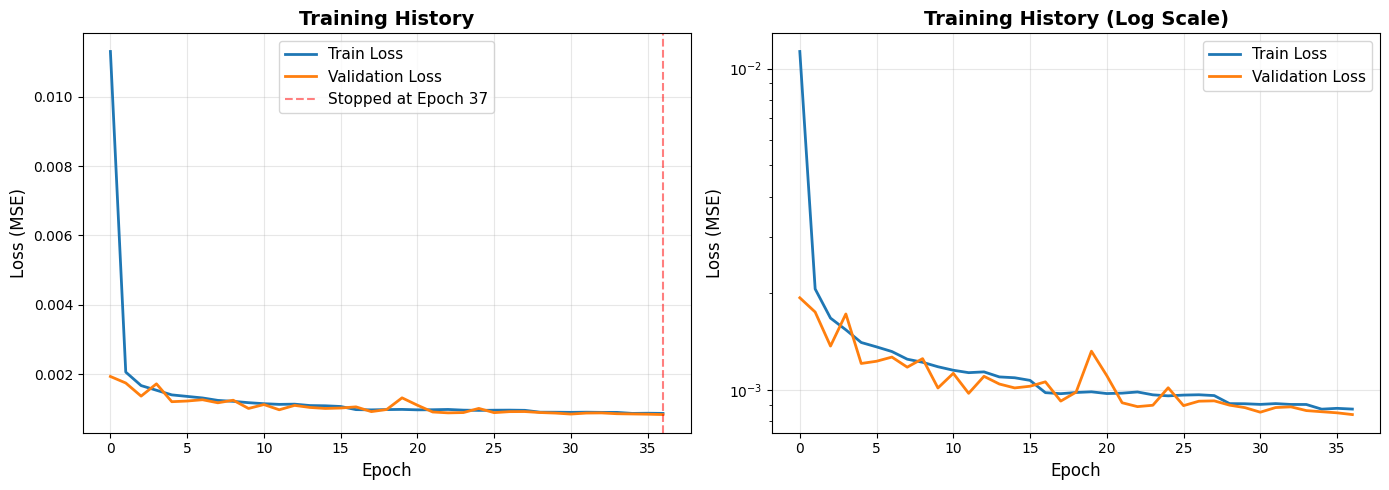

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(len(train_losses)-1, color='red', linestyle='--', alpha=0.5,
           label=f'Stopped at Epoch {len(train_losses)}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

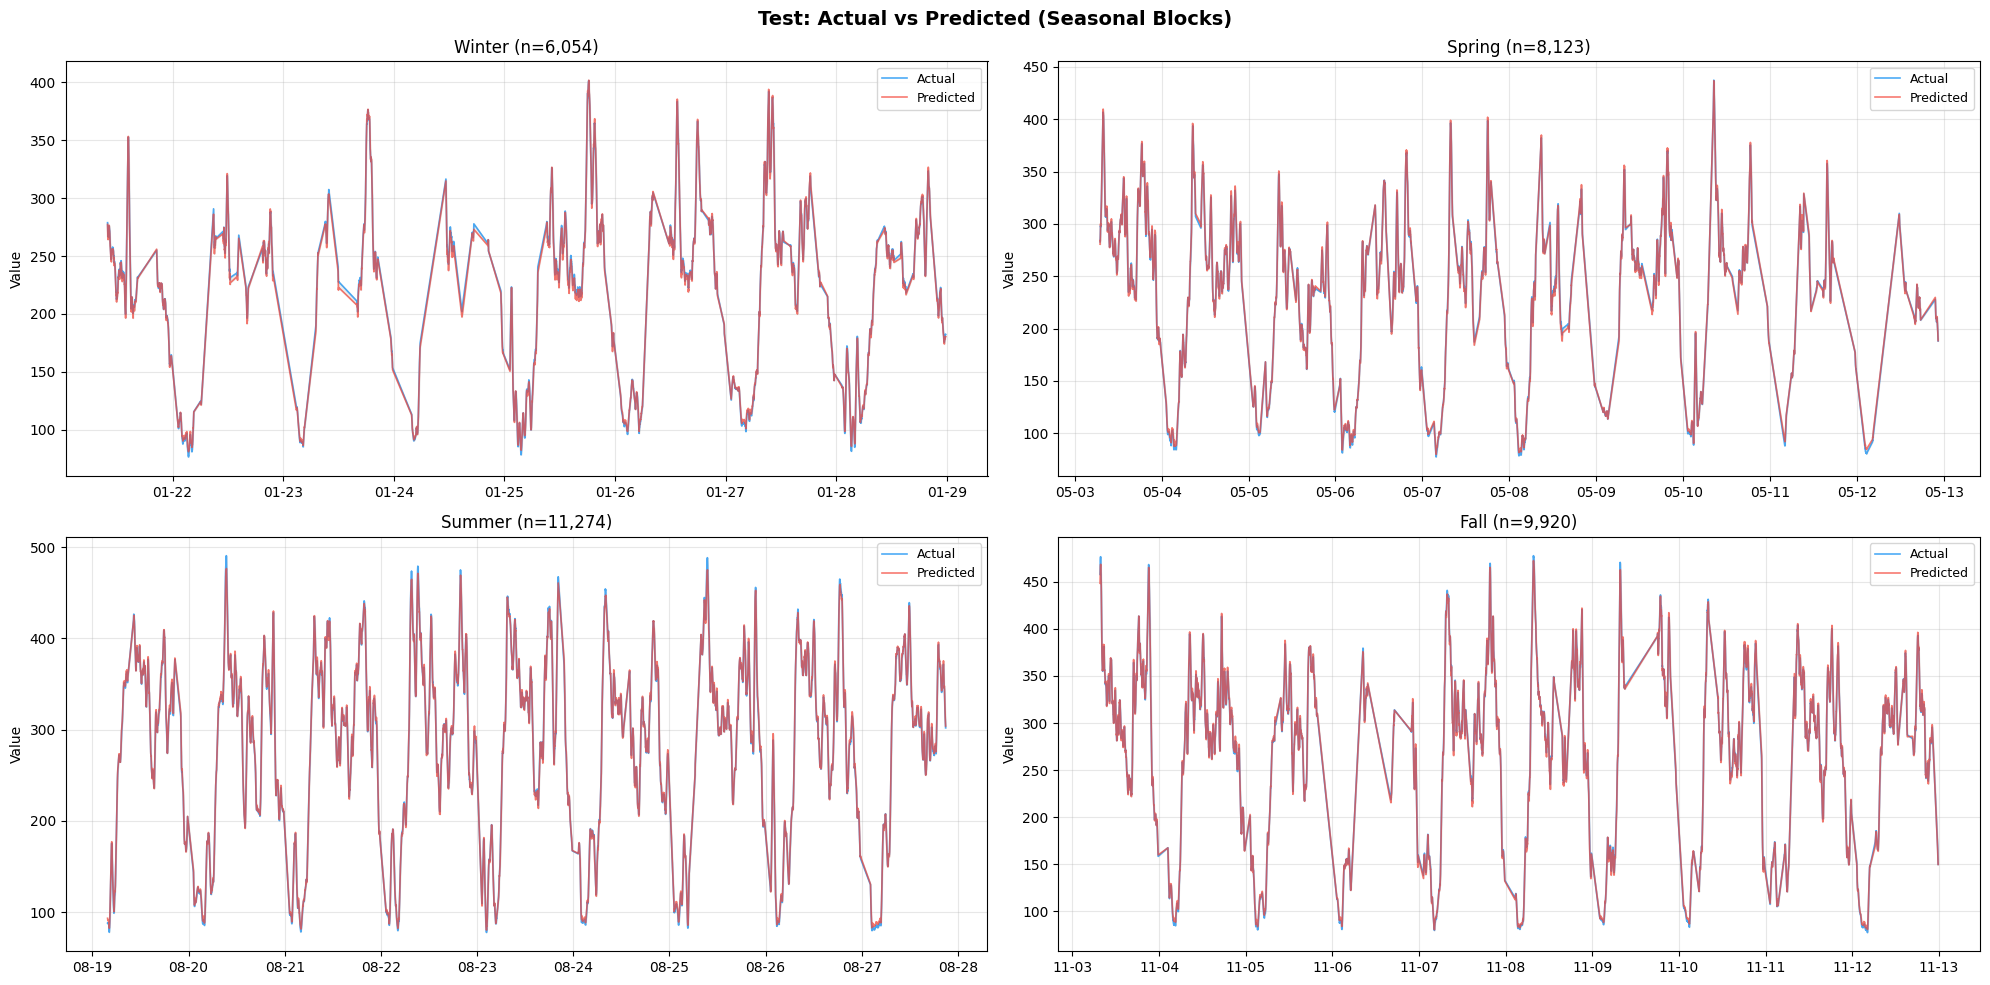

In [28]:
import matplotlib.dates as mdates

actual_series = test_actual_original[:, 0]
pred_series = test_pred_original[:, 0]
plot_times = pd.to_datetime(test_times[:len(actual_series)])

# 2x2 subplot: one per seasonal block
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Test: Actual vs Predicted (Seasonal Blocks)', fontsize=14, fontweight='bold')

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
offset = 0

for ax, name, size in zip(axes.flat, season_names, block_sizes):
    t = plot_times[offset:offset+size]
    a = actual_series[offset:offset+size]
    p = pred_series[offset:offset+size]

    ax.plot(t, a, label='Actual', linewidth=1.2, color='#2196F3', alpha=0.8)
    ax.plot(t, p, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.7)
    ax.fill_between(t, a, p, alpha=0.15, color='gray')
    ax.set_title(f'{name} (n={size:,})', fontsize=12)
    ax.set_ylabel('Value')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    offset += size

plt.tight_layout()
plt.show()

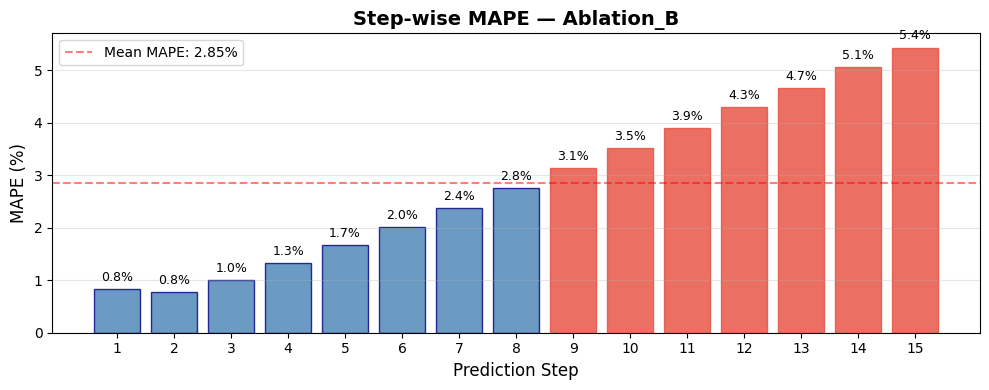


Step-wise MAPE:
  Step  1: 0.83%
  Step  2: 0.77%
  Step  3: 1.01%
  Step  4: 1.32%
  Step  5: 1.67%
  Step  6: 2.01%
  Step  7: 2.38%
  Step  8: 2.75%
  Step  9: 3.14%
  Step 10: 3.51%
  Step 11: 3.90%
  Step 12: 4.29%
  Step 13: 4.66%
  Step 14: 5.06%
  Step 15: 5.43% ← worst
  Mean:   2.85%


In [29]:
# Step별 MAPE 분석 — 후반 step 성능 저하 확인
step_mapes = []
for s in range(output_time):
    actual_s = test_actual_original[:, s]
    pred_s = test_pred_original[:, s]
    mask = actual_s != 0
    mape_s = np.mean(np.abs((actual_s[mask] - pred_s[mask]) / actual_s[mask])) * 100
    step_mapes.append(mape_s)

plt.figure(figsize=(10, 4))
bars = plt.bar(range(1, output_time + 1), step_mapes, color='steelblue', edgecolor='navy', alpha=0.8)

# 색상 강조: MAPE가 높은 step
for i, (bar, mape) in enumerate(zip(bars, step_mapes)):
    if mape > np.mean(step_mapes) * 1.1:  # 평균 대비 10% 이상이면 빨간색
        bar.set_color('#e74c3c')
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

plt.axhline(y=np.mean(step_mapes), color='red', linestyle='--', alpha=0.5, label=f'Mean MAPE: {np.mean(step_mapes):.2f}%')
plt.xlabel('Prediction Step', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title(f'Step-wise MAPE — {model_name}', fontsize=14, fontweight='bold')
plt.xticks(range(1, output_time + 1))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nStep-wise MAPE:")
for s, mape in enumerate(step_mapes):
    flag = " ← worst" if mape == max(step_mapes) else ""
    print(f"  Step {s+1:2d}: {mape:.2f}%{flag}")
print(f"  Mean:   {np.mean(step_mapes):.2f}%")

Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)

                    MAPE          RMSE           MAE            R2          Bias
----------------------------------------------------------------------
       All  +0.352%/step  +1.110/step  +0.850/step  -0.00240/step  -0.130/step
    Winter  +0.351%/step  +0.943/step  +0.721/step  -0.00275/step  -0.086/step
    Spring  +0.338%/step  +1.024/step  +0.785/step  -0.00290/step  -0.220/step
    Summer  +0.366%/step  +1.212/step  +0.934/step  -0.00248/step  -0.135/step
      Fall  +0.348%/step  +1.153/step  +0.886/step  -0.00253/step  -0.077/step

             Step 1 MAPE   Step 15 MAPE     Ratio   Step 1 R2   Step 15 R2
----------------------------------------------------------------------
       All        0.83%         5.43%      6.5x      0.9994       0.9658
    Winter        0.95%         5.48%      5.8x      0.9991       0.9614
    Spring        0.84%         5.23%      6.2x      0.9993       0.9584
    Summer        0.77%         5.57%      7.3x

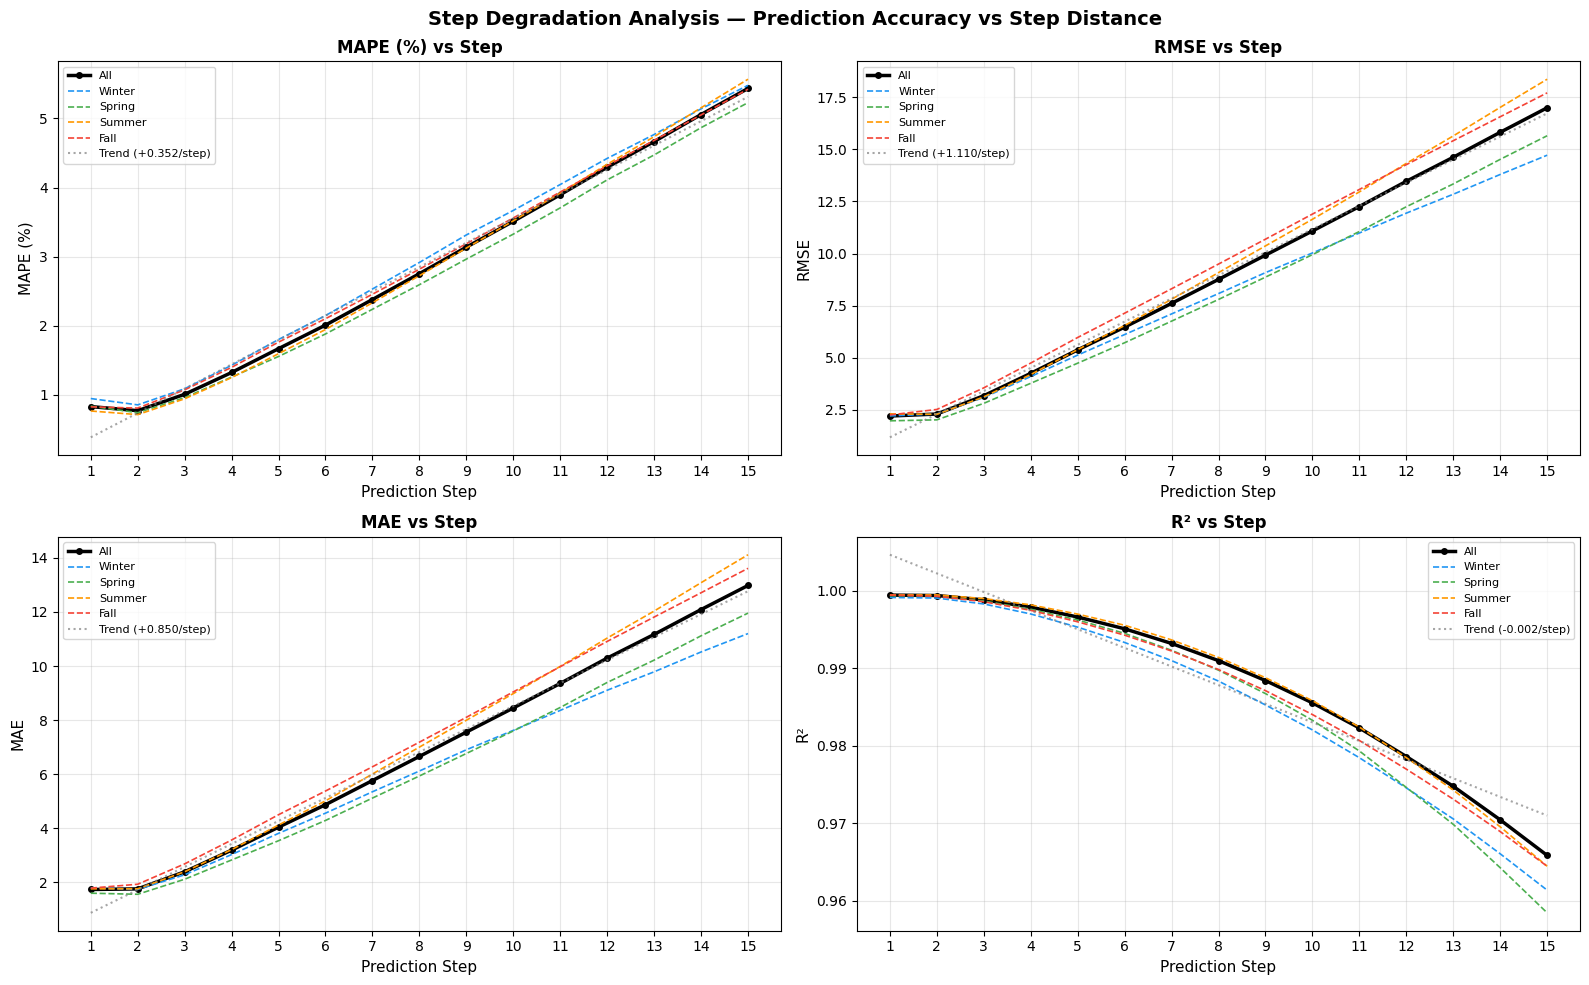


Step-weighted Loss 효과 분석
  Loss weight: Step 1 = 1.0, Step 15 = 2.0
  Step 1 MAPE: 0.83%
  Step 15 MAPE: 5.43%
  Ratio (Step15/Step1): 6.5x
  MAPE 증가율: 0.329%/step

  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 6.5배 증가.


In [30]:
# Step 증가에 따른 예측 정확도 감소 추세 (전체 + 계절별)
from sklearn.metrics import r2_score as r2_fn

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
steps = np.arange(1, output_time + 1)

# 1) 전체 + 계절별 Step-wise 지표 계산
results = {}  # {name: {metric: [step1, ..., step15]}}

# 전체
all_metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
for s in range(output_time):
    a = test_actual_original[:, s]
    p = test_pred_original[:, s]
    mask = a != 0
    all_metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
    all_metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
    all_metrics['MAE'].append(np.mean(np.abs(a - p)))
    all_metrics['R2'].append(r2_fn(a, p))
    all_metrics['Bias'].append(np.mean(a - p))
results['All'] = all_metrics

# 계절별
offset = 0
for name, size in zip(season_names, block_sizes):
    block_actual = test_actual_original[offset:offset + size]
    block_pred = test_pred_original[offset:offset + size]
    metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
    for s in range(output_time):
        a = block_actual[:, s]
        p = block_pred[:, s]
        mask = a != 0
        metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
        metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
        metrics['MAE'].append(np.mean(np.abs(a - p)))
        metrics['R2'].append(r2_fn(a, p))
        metrics['Bias'].append(np.mean(a - p))
    results[name] = metrics
    offset += size

# 2) 선형 회귀로 감소율(기울기) 계산
from numpy.polynomial.polynomial import polyfit
print("=" * 70)
print("Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)")
print("=" * 70)
print(f"\n{'':>10s}  {'MAPE':>12s}  {'RMSE':>12s}  {'MAE':>12s}  {'R2':>12s}  {'Bias':>12s}")
print("-" * 70)
for name in ['All'] + season_names:
    slopes = {}
    for metric in ['MAPE', 'RMSE', 'MAE', 'R2', 'Bias']:
        b, m = polyfit(steps, results[name][metric], 1)
        slopes[metric] = m
    print(f"{name:>10s}  {slopes['MAPE']:+.3f}%/step  "
          f"{slopes['RMSE']:+.3f}/step  {slopes['MAE']:+.3f}/step  "
          f"{slopes['R2']:+.5f}/step  {slopes['Bias']:+.3f}/step")

# Step 1 vs Step 15 비교
print(f"\n{'':>10s}  {'Step 1 MAPE':>12s}  {'Step 15 MAPE':>13s}  {'Ratio':>8s}  {'Step 1 R2':>10s}  {'Step 15 R2':>11s}")
print("-" * 70)
for name in ['All'] + season_names:
    m1 = results[name]['MAPE'][0]
    m15 = results[name]['MAPE'][-1]
    r1 = results[name]['R2'][0]
    r15 = results[name]['R2'][-1]
    print(f"{name:>10s}  {m1:10.2f}%  {m15:11.2f}%  {m15/m1:7.1f}x  {r1:10.4f}  {r15:11.4f}")

# 3) 시각화: 4개 지표 × (전체 + 계절별)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Step Degradation Analysis — Prediction Accuracy vs Step Distance',
             fontsize=14, fontweight='bold')

colors = {'All': 'black', 'Winter': '#2196F3', 'Spring': '#4CAF50',
          'Summer': '#FF9800', 'Fall': '#F44336'}
linewidths = {'All': 2.5, 'Winter': 1.2, 'Spring': 1.2, 'Summer': 1.2, 'Fall': 1.2}

for ax, metric, ylabel in zip(axes.flat,
    ['MAPE', 'RMSE', 'MAE', 'R2'],
    ['MAPE (%)', 'RMSE', 'MAE', 'R²']):

    for name in ['All'] + season_names:
        vals = results[name][metric]
        ax.plot(steps, vals, label=name, color=colors[name],
                linewidth=linewidths[name],
                linestyle='-' if name == 'All' else '--',
                marker='o' if name == 'All' else None,
                markersize=4)

    # 전체 추세선
    b, m = polyfit(steps, results['All'][metric], 1)
    trend = b + m * steps
    ax.plot(steps, trend, color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'Trend ({m:+.3f}/step)')

    ax.set_xlabel('Prediction Step', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'{ylabel} vs Step', fontsize=12, fontweight='bold')
    ax.set_xticks(steps)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Step-weighted Loss 효과 분석
print("\n" + "=" * 70)
print("Step-weighted Loss 효과 분석")
print("=" * 70)
print(f"  Loss weight: Step 1 = 1.0, Step 15 = 2.0")
print(f"  Step 1 MAPE: {results['All']['MAPE'][0]:.2f}%")
print(f"  Step 15 MAPE: {results['All']['MAPE'][-1]:.2f}%")
print(f"  Ratio (Step15/Step1): {results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}x")
print(f"  MAPE 증가율: {(results['All']['MAPE'][-1]-results['All']['MAPE'][0])/(output_time-1):.3f}%/step")
print(f"\n  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 "
      f"{results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}배 증가.")

In [ ]:
# Best run 모델 저장 (J배수지)
model_path = BASE_DIR / "models" / "j_resv_seq2seq.pth"

# A배수지
# model_path = BASE_DIR / "models" / "a_resv_seq2seq.pth"

# D배수지
# model_path = BASE_DIR / "models" / "d_resv_seq2seq.pth"


torch.save({
    'model_name': model_name,
    'model_state_dict': model.state_dict(),
    'scalers': {col: {'min': scalers[col].data_min_[0], 'max': scalers[col].data_max_[0]} for col in scale_cols},
    'feature_cols': feature_cols,
    'scale_cols': scale_cols,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': best_run['mape'],
    'best_epoch': len(train_losses),
    'best_seed': best_run['seed'],
    'input_time': input_time,
    'output_time': output_time,
}, model_path)

print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /home/kp/web/work/pro/models/lstm_weather_time_a.pth
